In [1]:
from torch_geometric.datasets import BA2MotifDataset

dataset = BA2MotifDataset(root='data/BA2Motif')

In [2]:
from model.gin import GIN
from torch_geometric.data import DataLoader
import torch
import random
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=5,
).to(device)

model.load_state_dict(torch.load('model/model.pth'))

model.eval()

def add_bidirectional_edges(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i].tolist()
        edge = tuple(sorted((u, v)))
        
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])

    bidirectional_edges = []
    for u, v in unique_edges:
        bidirectional_edges.append([u, v])
        bidirectional_edges.append([v, u])
    
    return torch.tensor(bidirectional_edges, dtype=torch.long).T

In [3]:
import torch.nn.functional as F
G1 = dataset[1]
G2 = dataset[999]

prob1, embedding1 = model.predict(G1.x, G1.edge_index, None, 1, True)
prob2, embedding2 = model.predict(G2.x, G2.edge_index, None, 1, True)
print(embedding1.shape)
u1 = F.softmax(embedding1, dim=1)
u2 = F.softmax(embedding2, dim=1)
print(u1)
distance = torch.norm(u1 - u2, p=2).item()
distance

torch.Size([1, 32])
tensor([[2.5754e-07, 5.7245e-04, 1.0944e-02, 2.0626e-07, 3.1785e-07, 1.1414e-04,
         1.9487e-07, 7.1898e-01, 1.0980e-02, 1.9487e-07, 1.6346e-01, 3.1915e-05,
         5.0835e-07, 1.2179e-04, 3.1023e-07, 2.3349e-07, 2.2410e-03, 4.0740e-02,
         1.9487e-07, 1.9487e-07, 1.4107e-05, 5.0620e-02, 1.9487e-07, 1.9487e-07,
         3.0729e-07, 1.9487e-07, 1.0989e-03, 8.0410e-05, 1.9487e-07, 1.9487e-07,
         1.9487e-07, 1.9487e-07]], grad_fn=<SoftmaxBackward0>)


0.8590918183326721

In [25]:


class GraphGenome:
    def __init__(self, data):
        self.num_nodes = data.x.size(0)
        self.x = data.x.clone()
        self.edge_index = data.edge_index.clone().to(device)
        self.fitness = 0
        
    def to_data(self):
        return Data(x=self.x, edge_index=self.edge_index)
    
    def clone(self):
        return GraphGenome(Data(x=self.x.clone().to(device), edge_index=self.edge_index.clone().to(device)))
    
    def eval_fitness_sso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        '''
        self: child
        embedding : graph embedding
        prob: xác suất cho từng class (đã qua softmax)
        '''
        prob_X, embedding_X = blackbox.predict(graphX.x, add_bidirectional_edges(graphX.edge_index), None, 1, True)
        prob_G, embedding_G = blackbox.predict(self.x, add_bidirectional_edges(self.edge_index), None, 1, True)
        
        uX = F.softmax(embedding_X, dim=1)
        uG = F.softmax(embedding_G, dim=1)
        
        distance = torch.norm(prob_X - prob_G, p=2).item() # euclide kc
        if distance <= 0:
            distance = 1
        #distance = 0 if prob_X.argmax().item() == prob_G.argmax().item() else 1
        
        print('distance: ', distance, ' ---- label: ', prob_G.argmax().item(), ' ---- prob: ', prob_G)
        return distance
    
    def eval_fitness_sdo(self, graphX, blackbox, distance_function, alpha1, alpha2, DO_graphs_embedding):
        '''
        self: child
        DO_graphs_embedding: list graph embedding của các graph không cùng class với graphX
        '''
        prob_G, embedding_G = blackbox.predict(self.x, add_bidirectional_edges(self.edge_index), None, 1, True)
        uG = F.softmax(embedding_G, dim=1)
        distances = []
        for embedding in DO_graphs_embedding:
            #uX = embedding
            prob_X = embedding
            distance = torch.norm(prob_X - prob_G, p=2).item()
            #distance = 0 if prob_X.argmax().item() == prob_G.argmax().item() else 1
            distances.append(distance)
        
        distance = min(distances)
        if distance <= 0:
            distance = 1

        print('distance: ', distance, ' ---- label: ', prob_G.argmax().item(), ' ---- prob: ', prob_G)
        return distance
    
    def eval_fitness_dso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity <= 0 else 1.0 - similarity
        
        y_X = blackbox.predict(graphX.x, add_bidirectional_edges(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, add_bidirectional_edges(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X == y_G else 0.0
        
        #print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_ddo(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity <= 0 else 1.0 - similarity
        
        y_X = blackbox.predict(graphX.x, add_bidirectional_edges(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, add_bidirectional_edges(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X != y_G else 0.0
        
        #print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def mutate(self, graphX, blackbox, distance_function, alpha1, alpha2, case_type, DO_graphs):
        edge_list = set(tuple(edge.tolist()) for edge in self.edge_index.T)
        num_nodes = self.num_nodes
        
        if random.random() <= 0.5:
            u, v = random.sample(range(num_nodes), 2)
            edge = (u, v) if u < v else (v, u)
            if edge not in edge_list:
                edge_list.add(edge)
        else:  
            if edge_list:
                edge = random.choice(list(edge_list))
                edge_list.remove(edge)
        
        new_edge_index = torch.tensor(list(edge_list), dtype=torch.long).T
    
        new_x = self.x.clone()
        # mutation_rate = 0.1
        # for i in range(self.num_nodes):
        #     if random.random() < mutation_rate:
        #         if torch.all((new_x[i] == 0) | (new_x[i] == 1)):  
        #             current_category = torch.argmax(new_x[i]).item()
        #             new_category = random.choice([j for j in range(new_x.size(1)) if j != current_category])
        #             new_x[i] = torch.zeros_like(new_x[i])
        #             new_x[i][new_category] = 1
        #         else:
        #             noise = torch.randn_like(new_x[i]) * 0.05
        #             new_x[i] = torch.nn.functional.softmax(new_x[i] + noise, dim=0)
                
        mutated_graph = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        
        if case_type == 'sso':
            mutated_graph.fitness = mutated_graph.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            mutated_graph.fitness = mutated_graph.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2, DO_graphs)
        elif case_type == 'dso':
            mutated_graph.fitness = mutated_graph.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            mutated_graph.fitness = mutated_graph.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)
            
        return mutated_graph
    
    def crossover(self, other, graphX, blackbox, distance_function, alpha1, alpha2, case_type, DO_graphs):
        parent1_edges = [tuple(edge.tolist()) for edge in self.edge_index.T]
        parent2_edges = [tuple(edge.tolist()) for edge in other.edge_index.T]

        if len(parent1_edges) < 2 or len(parent2_edges) < 2:
            return self  

        parent_size = len(parent1_edges)
        cut1, cut2 = sorted(random.sample(range(parent_size), 2))
        child_edges = parent1_edges[:cut1] + parent2_edges[cut1:cut2] + parent1_edges[cut2:]

        child_edges = list(set(child_edges))  
        
        new_edge_index = torch.tensor(child_edges, dtype=torch.long).T
        child = GraphGenome(Data(x=self.x.clone(), edge_index=new_edge_index))
        
        if case_type == 'sso':
            child.fitness = child.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            child.fitness = child.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2, DO_graphs)
        elif case_type == 'dso':
            child.fitness = child.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            child.fitness = child.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)

        return child



def initialize_population(size, graphX, blackbox, distance_function, alpha1, alpha2, case_type, DO_graphs):
    population = []
    for _ in range(size):
        individual = GraphGenome(graphX).mutate(graphX, blackbox, distance_function, alpha1, alpha2, case_type, DO_graphs)
        population.append(individual)
    
    for individual in population:
        if case_type == 'sso':
            individual.fitness = individual.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            individual.fitness = individual.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2, DO_graphs)
        elif case_type == 'dso':
            individual.fitness = individual.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            individual.fitness = individual.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)
            
    return population

def select_parents(population, ratio):
    population.sort(key=lambda individual: individual.fitness)
    return population[:int(ratio * len(population))]

def get_graphs_DO_embedding(label, dataset, blackbox):
    DO_graphs_embedding = []
    for i in range(len(dataset)):
        if dataset[i].y != label:
            prob_X, embedding_X = blackbox.predict(dataset[i].x, dataset[i].edge_index, None, 1, True)
        
            uX = F.softmax(embedding_X, dim=1)
            DO_graphs_embedding.append(prob_X)
    return DO_graphs_embedding

def genetic_algorithm(graphX, populationSize, generations, blackbox, distance_function, alpha1, alpha2):
    case_population_size = populationSize // 2
    case_type = ['sso', 'sdo']
    populations = {}
    DO_graphs_embedding = get_graphs_DO_embedding(graphX.y, dataset, blackbox)
        
    for type in case_type:
        populations[type] = initialize_population(
                    case_population_size, graphX, blackbox, distance_function, alpha1, alpha2, type, DO_graphs_embedding
                )
        for gen in range(generations):
            print(f"{type} : Generation {gen+1}/{generations} =====")
            new_population = []
            best_individuals = select_parents(populations[type], 0.1)
            new_population.extend(best_individuals[:len(best_individuals) // 2])
            while len(new_population) < case_population_size:
                parent1, parent2 = random.sample(best_individuals, 2)
                child = parent1.crossover(parent2, graphX, blackbox, distance_function, alpha1, alpha2, type, DO_graphs_embedding)
                child = child.mutate(graphX, blackbox, distance_function, alpha1, alpha2, type, DO_graphs_embedding)
                    
                new_population.append(child)
                    
            populations[type] = new_population
    
    return populations
    final_population = []
    for population in populations.values():
        final_population.extend(population)
        
    return final_population

In [26]:
from distance import *
import pickle


with open("graph2X_0.pkl", "rb") as f:
    graphX = pickle.load(f)
graphX.edge_index = remove_bidirectional_edge(graphX.edge_index)
final_population = genetic_algorithm(graphX = graphX, populationSize=400, generations=20, blackbox=model, 
                                     distance_function=my_distance2, 
                                     alpha1=0.5, alpha2=0.5)


distance:  3.792742231389923e-10  ---- label:  0  ---- prob:  tensor([[1.0000e+00, 7.8823e-10]], grad_fn=<SoftmaxBackward0>)
distance:  4.0171066473249084e-10  ---- label:  0  ---- prob:  tensor([[1.0000e+00, 7.6579e-10]], grad_fn=<SoftmaxBackward0>)
distance:  1.867520582621296e-10  ---- label:  0  ---- prob:  tensor([[1.0000e+00, 1.3543e-09]], grad_fn=<SoftmaxBackward0>)
distance:  2.0428514435621992e-10  ---- label:  0  ---- prob:  tensor([[1.0000e+00, 9.6322e-10]], grad_fn=<SoftmaxBackward0>)
distance:  1.703183869494751e-07  ---- label:  0  ---- prob:  tensor([[1.0000e+00, 1.2281e-07]], grad_fn=<SoftmaxBackward0>)
distance:  1.176308512687683  ---- label:  1  ---- prob:  tensor([[0.1682, 0.8318]], grad_fn=<SoftmaxBackward0>)
distance:  2.880730562537792e-06  ---- label:  0  ---- prob:  tensor([[1.0000e+00, 2.0485e-06]], grad_fn=<SoftmaxBackward0>)
distance:  3.792742231389923e-10  ---- label:  0  ---- prob:  tensor([[1.0000e+00, 7.8823e-10]], grad_fn=<SoftmaxBackward0>)
distance: 

In [19]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import math
type = 'sdo'
population = sorted(final_population[type], key=lambda x: x.fitness)

num_mutated = len(population)
total_graphs = num_mutated + 1

# Cấu hình layout
cols = 4
rows = math.ceil(total_graphs / cols)

def layout(G):
    return nx.spring_layout(G, seed=42)

# Tạo subplot
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

# Vẽ graph gốc (graphX)
G_original = to_networkx(graphX, to_undirected=True)
pos_original = layout(G_original)
nx.draw(G_original, with_labels=True, pos=pos_original, ax=axes[0])
axes[0].set_title("Original Graph")

# Vẽ các graph mutated
for i, individual in enumerate(population):
    ax = axes[i + 1]  # vị trí sau graph gốc
    graph_mutated = Data(x=individual.x, edge_index=individual.edge_index)
    G_mutated = to_networkx(graph_mutated, to_undirected=True)
    nx.draw(G_mutated, with_labels=True, pos=pos_original, ax=ax)

    prediction = model.predict(
        graph_mutated.x,
        ensure_undirected(graph_mutated.edge_index),
        None, 1
    ).argmax(dim=-1).item()

    ax.set_title(f"Fitness: {individual.fitness:.2f}\nPred: {prediction}")

for i in range(total_graphs, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx, remove_isolated_nodes, to_undirected
from torch_geometric.data import Data

def generate_population_dataframe(population, model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    
    records = []
    
    for i, individual in enumerate(population):
        graph = to_networkx(individual.to_data(), to_undirected=True)
        
        pos = nx.spring_layout(graph, seed=42)
        fig, ax = plt.subplots(figsize=(4, 4))
        nx.draw(graph, with_labels=True, ax=ax, pos=pos_original, node_size=120, font_size=8)
        img_path = os.path.join(save_dir, f"graph_{i}.png")
        plt.savefig(img_path, bbox_inches='tight')
        plt.close(fig)
        
        with torch.no_grad():
            probs, graph_emb = model.predict(individual.x, add_bidirectional_edges(individual.edge_index), None, batch_size=1, get_embeddings=True)
            pred = probs.argmax().item()
            embedding = F.softmax(graph_emb, dim=-1).squeeze().cpu().numpy()
            embedding = embedding.tolist()
            embedding = [round(x, 4) for x in embedding]

        records.append({
            "img_path": img_path,
            "prediction": pred,
            "output": probs.squeeze().cpu().numpy().tolist(),
            "embedding": embedding,
            "fitness": getattr(individual, 'fitness', None)  # nếu có
        })

    return pd.DataFrame(records)


In [28]:
final_population['sso'] = sorted(final_population['sso'], key=lambda x: x.fitness)
final_population['sdo'] = sorted(final_population['sdo'], key=lambda x: x.fitness)
df_sso = generate_population_dataframe(final_population['sso'], model, save_dir="visualization/population_sso")
df_sdo = generate_population_dataframe(final_population['sdo'], model, save_dir="visualization/population_sdo")
df_sdo.to_csv("visualization/population_sdo.csv", index=False)
df_sso.to_csv("visualization/population_sso.csv", index=False)

graph_X = to_networkx(graphX, to_undirected=True)
pos = nx.spring_layout(graph_X, seed=42)
fig, ax = plt.subplots(figsize=(4, 4))
nx.draw(graph_X, with_labels=True, ax=ax, pos=pos_original, node_size=120, font_size=8)
img_path = os.path.join("visualization", f"graph_X.png")
plt.savefig(img_path, bbox_inches='tight')
plt.close(fig)

In [29]:
def visualize(df, file_name):
    f = open(file_name, "wt", encoding='utf-8')
    f.write("<html>\n")
    f.write("<body>\n")
    f.write("<h2>Final population</h2>\n")
    f.write("<table border='1' cellspacing='0' cellpadding='10'>\n")
    f.write("<h2 style='text-align: center;'><img src='visualization/graph_X.png' width='300'></h2>")
    for i in range(df.shape[0]):
        row = df.iloc[i]
        img_path = row['img_path']
        pred = row['prediction']
        embedding = row['embedding']

        f.write("<tr>")
        f.write(f"<td><img src='{img_path}' width='300' height='300'></td>")
        f.write(f"<td><b>Prediction:</b> {pred}<br><b>Embedding:</b> [{embedding}]<br><b>Output:</b> {row['output']}</td>")
        f.write(f"<td><b>Distance:</b> {row['fitness']}</td>")
        f.write("</tr>\n")
    f.write("</table>\n")
    f.write("</body>\n")
    f.write("</html>\n")
    f.close()

visualize(df_sso, "population_sso.html")
visualize(df_sdo, "population_sdo.html")

In [15]:
import pandas as pd
import torch
import numpy as np
from model.gin import *

population = final_population['sso'] + final_population['sdo']
df = prepare_dataframe(population, model, device, ground_truth=False, only_edge=True)
df.head()

n0_n0  n0_n1  n0_n2  n0_n3  n0_n4  n0_n5  n0_n6  n0_n7  n0_n8  n0_n9  ...  \
0      0      1      1      1      1      0      0      1      1      1  ...   
1      0      1      1      1      1      0      0      1      1      1  ...   
2      0      1      1      1      1      0      0      1      1      1  ...   
3      0      1      1      1      1      0      0      1      1      0  ...   
4      0      1      1      1      1      0      0      1      1      0  ...   

   n21_n22  n21_n23  n21_n24  n22_n22  n22_n23  n22_n24  n23_n23  n23_n24  \
0        1        0        0        0        1        0        0        1   
1        1        0        0        0        1        0        0        1   
2        1        0        0        0        1        0        0        1   
3        1        0        0        0        1        0        0        1   
4        1        0        0        0        1        0        0        1   

   n24_n24  y  
0        0  0  
1        0  0  
2        0  0  
3        0  0  
4        0  0  

[5 rows x 326 columns]

In [16]:
# count number of row has y = 1
class_1 = df[df['y'] == 1].shape[0]
class_0 = df[df['y'] == 0].shape[0]
class_1, class_0


(174, 226)

In [ ]:
df[:5]

n0_n0  n0_n1  n0_n2  n0_n3  n0_n4  n0_n5  n0_n6  n0_n7  n0_n8  n0_n9  ...  \
0      0      1      0      1      1      0      0      0      1      0  ...   
1      0      1      0      1      0      0      0      0      0      0  ...   
2      0      1      0      1      1      0      0      0      0      0  ...   
3      0      1      0      1      0      0      0      0      1      0  ...   
4      0      0      0      1      1      0      0      0      0      0  ...   

   n21_n22  n21_n23  n21_n24  n22_n22  n22_n23  n22_n24  n23_n23  n23_n24  \
0        1        0        0        0        1        0        0        1   
1        1        0        0        0        1        0        0        0   
2        1        0        0        0        1        0        0        1   
3        1        0        0        0        1        0        0        1   
4        0        0        0        0        0        0        0        0   

   n24_n24  y  
0        0  0  
1        0  0  
2        0  0  
3        0  0  
4        0  0  

[5 rows x 326 columns]

In [ ]:
df.to_pickle("generate_sample.pkl")

In [ ]:
df_loaded = pd.read_pickle("generate_sample.pkl")
df_loaded.shape


(1000, 351)

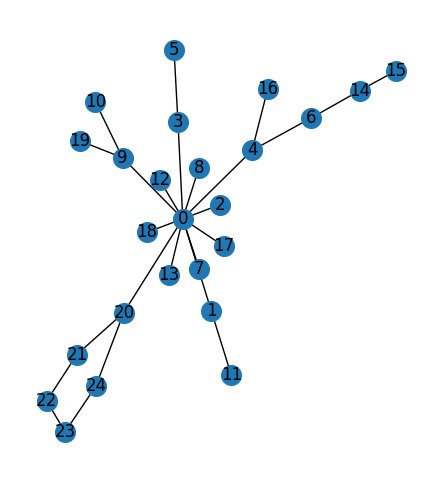

In [ ]:
import pickle
from torch_geometric.utils import to_networkx

def load_graphs_from_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

loaded_graphs = dataset[72]
G1 = to_networkx(loaded_graphs, to_undirected=True)
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw(G1, with_labels=True, cmap="coolwarm", node_size=200)


# permuted = load_graphs_from_pickle("graph_permutate.pkl")
# G2 = to_networkx(permuted, to_undirected=True)
# plt.subplot(122)
# nx.draw(G2, with_labels=True, cmap="coolwarm", node_size=200)
# plt.show()

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
mutag = TUDataset(root="TUDataset", name="MUTAG")

In [ ]:
def pad_matrix(matrix, target_size):
    pad_size = target_size - matrix.shape[0]
    if pad_size > 0:
        pad_matrix = torch.zeros((pad_size, matrix.shape[1]), dtype=matrix.dtype, device=matrix.device)
        matrix = torch.cat([matrix, pad_matrix], dim=0)
        
        pad_matrix = torch.zeros((matrix.shape[0], pad_size), dtype=matrix.dtype, device=matrix.device)
        matrix = torch.cat([matrix, pad_matrix], dim=1)
    return matrix

def pad_features(features, target_size):
    pad_size = target_size - features.shape[0]
    if pad_size > 0:
        pad_matrix = torch.zeros((pad_size, features.shape[1]), dtype=features.dtype, device=features.device)
        features = torch.cat([features, pad_matrix], dim=0)
    return features

def my_distance(data1, data2, adj_weight=0.5, feature_weight=0.5, normalize=True):
    max_nodes = max(data1.num_nodes, data2.num_nodes)

    # Chuyển edge_index thành ma trận kề
    data1.edge_index = ensure_undirected(data1.edge_index)
    data2.edge_index = ensure_undirected(data2.edge_index)
    
    adj1 = torch.zeros((data1.num_nodes, data1.num_nodes), dtype=torch.float32)
    adj1[data1.edge_index[0], data1.edge_index[1]] = 1
    adj1 = pad_matrix(adj1, max_nodes)

    adj2 = torch.zeros((data2.num_nodes, data2.num_nodes), dtype=torch.float32)
    adj2[data2.edge_index[0], data2.edge_index[1]] = 1
    adj2 = pad_matrix(adj2, max_nodes)

    # Tính khoảng cách Frobenius giữa ma trận kề
    adj_distance = torch.norm(adj1 - adj2, p='fro')

    # Padding feature matrix 
    if data1.x is not None and data2.x is not None:
        feature_dim = data1.x.shape[1]  # Giữ nguyên số chiều đặc trưng
        feature1 = pad_features(data1.x, max_nodes)
        feature2 = pad_features(data2.x, max_nodes)
        feature_distance = torch.norm(feature1 - feature2, p='fro')
    else:
        feature_distance = torch.tensor(0.0)

    # Chuẩn hóa khoảng cách về [0,1]
    if normalize:
        max_adj_dist = torch.norm(torch.ones_like(adj1), p='fro')  # Khoảng cách tối đa có thể có
        max_feat_dist = torch.norm(torch.ones_like(feature1), p='fro') if data1.x is not None else 1.0

        adj_distance = adj_distance / max_adj_dist
        feature_distance = feature_distance / max_feat_dist

    total_distance = adj_weight * adj_distance + feature_weight * feature_distance

    return {
        "adj_distance": adj_distance.item(),
        "feature_distance": feature_distance.item(),
        "total_distance": total_distance.item()
    }

In [ ]:
A = dataset[0]
B = dataset[700]
parent1_edges = [tuple(edge.tolist()) for edge in filter_undirected_edges(A.edge_index).T]
parent2_edges = [tuple(edge.tolist()) for edge in filter_undirected_edges(B.edge_index).T]
print(parent1_edges)
print(parent2_edges)
cut = random.randint(1, len(parent1_edges) - 1)
print(cut)
print(parent1_edges[:cut])
print(parent2_edges[cut:])
child_edges = parent1_edges[:cut] + parent2_edges[cut:]
# print(cut1, cut2)
# child_edges = parent1_edges[:cut1] + parent2_edges[cut1:cut2] + parent1_edges[cut2:]
print(child_edges)
child_edges = list(set(child_edges))  
new_edge_index = torch.tensor(child_edges, dtype=torch.long).T


[(0, 1), (0, 3), (0, 4), (0, 7), (0, 13), (0, 14), (0, 16), (0, 18), (0, 20), (1, 2), (1, 5), (1, 9), (2, 10), (4, 12), (4, 17), (5, 6), (5, 8), (6, 11), (13, 15), (15, 19), (20, 21), (20, 24), (21, 22), (22, 23), (23, 24)]
[(0, 1), (0, 4), (0, 17), (0, 20), (1, 2), (1, 3), (1, 5), (1, 9), (1, 13), (1, 19), (3, 7), (3, 14), (4, 6), (5, 8), (5, 15), (5, 16), (6, 10), (6, 11), (6, 12), (8, 18), (20, 21), (20, 23), (20, 24), (21, 22), (21, 24), (22, 23)]
23
[(0, 1), (0, 3), (0, 4), (0, 7), (0, 13), (0, 14), (0, 16), (0, 18), (0, 20), (1, 2), (1, 5), (1, 9), (2, 10), (4, 12), (4, 17), (5, 6), (5, 8), (6, 11), (13, 15), (15, 19), (20, 21), (20, 24), (21, 22)]
[(21, 22), (21, 24), (22, 23)]
[(0, 1), (0, 3), (0, 4), (0, 7), (0, 13), (0, 14), (0, 16), (0, 18), (0, 20), (1, 2), (1, 5), (1, 9), (2, 10), (4, 12), (4, 17), (5, 6), (5, 8), (6, 11), (13, 15), (15, 19), (20, 21), (20, 24), (21, 22), (21, 22), (21, 24), (22, 23)]


In [ ]:
def my_distance2(data1, data2, adj_weight=0.5, feature_weight=0.5):
    data1.edge_index = ensure_undirected(data1.edge_index)
    data2.edge_index = ensure_undirected(data2.edge_index)
    
    edges_1 = set(tuple(edge.tolist()) for edge in data1.edge_index.T)
    edges_2 = set(tuple(edge.tolist()) for edge in data2.edge_index.T)
    
    num_common_edges = len(edges_1.intersection(edges_2))
    num_total_edges = len(edges_1.union(edges_2))
    adj_distance = 1.0 - num_common_edges / num_total_edges
    
    max_nodes = max(data1.x.shape[0], data2.x.shape[0])
    feature_distance = torch.tensor(0.0)
    if data1.x is not None and data2.x is not None:
        feature1 = pad_features(data1.x, max_nodes)
        feature2 = pad_features(data2.x, max_nodes)
        feature_distance = torch.norm(feature1 - feature2, p='fro')
    else:
        feature_distance = torch.tensor(0.0)
    
    feature_distance = feature_distance / torch.norm(torch.ones_like(feature1), p='fro')
    
    total_distance = adj_weight * adj_distance + feature_weight * feature_distance
    return total_distance.item()


In [ ]:
graphA = dataset[0]
print("Graph A:", graphA.edge_index.size())
graphX = dataset[6]
my_distance2(graphA, graphX)

Graph A: torch.Size([2, 50])


0.39024388790130615